In [96]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 20)
plt.rcParams['font.family'] = "Malgun Gothic"
# csv 읽어오기, 현재 위치에 해당 파일이 없으면 첫번째 파라미터에 정확한 경로를 포함한 파일명 기입
df = pd.read_csv('모두컴퍼니_기술과제/실전DB.csv')# 'cp949', 'euc-kr'
df = df.rename(columns=str.lower)
df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


## 전처리

1. dtype < - datetime형식으로 변경
2. 1970년도 데이터 삭제 <- 이상치
3. 유저 아이디 99964 삭제 <- 이상치

#### dtype

join_date와 date부분 datetime 형식으로 변경

In [97]:
# dtype 수정
df[['user_id', 'store_id']] = df[['user_id', 'store_id']].astype(object)
df[['join_date', 'date']] = df[['join_date', 'date']].apply(lambda X : pd.to_datetime(X))

#### 1970년도 데이터 삭제,  유저 아이디 999664 삭제

In [98]:
df = df[~(df['join_date']=='1970-01-01')]
df = df[~(df['user_id']== 999665)]

#### 추가 컬럼

In [99]:
df['join_yearmonth'] = df['join_date'].dt.year.astype(str) + '-' +df['join_date'].dt.month.astype(str)
df['join_year'] = df['join_date'].dt.year.astype(str)
df['pay_yearmonth'] = df['date'].dt.year.astype(str) + '-' +df['date'].dt.month.astype(str)
df['pay_dow'] = df['date'].dt.day_name()
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,join_year,pay_yearmonth,pay_dow
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-1,2014,2020-1,Wednesday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-2,2014,2020-1,Wednesday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2014,2020-1,Wednesday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2014,2020-1,Wednesday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2014,2020-1,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020,2020-12,Thursday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020,2020-12,Thursday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020,2020-12,Thursday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020,2020-12,Thursday


## count, user간의 상관관계 분석

### 2020 결재한 사람을 월별로 분류

In [100]:
df_user = df.groupby('join_yearmonth')['user_id'].nunique().reset_index()
df_user.rename(columns = {'user_id': 'user_count'}, inplace= True)
df_user

,join_yearmonth,user_count
0,2013-12,9
1,2014-1,14
2,2014-10,119
3,2014-11,133
4,2014-12,117
...,...,...
80,2020-5,6621
81,2020-6,7036
82,2020-7,7858
83,2020-8,7113


### 2020 결재한 count 개수를 월별로 분류

In [102]:
df_count = df.groupby('join_yearmonth')['count'].sum().reset_index()
df_count

,join_yearmonth,count
0,2013-12,38
1,2014-1,113
2,2014-10,500
3,2014-11,682
4,2014-12,791
...,...,...
80,2020-5,34079
81,2020-6,35782
82,2020-7,35300
83,2020-8,30689


### 월별 가입자들의 평균 count

#### 가설: 
1. 2020 결재일 데이터 이기 때문에 가입한지 오래된 사람들은 아닌 사람들보다 더 결제를 많이 했을것이다.

-------------

#### 계산 순서:
1. 월별 가입자 분류
2. 월별 count 분류
3. 월별 count / 월별 가입자 = '월별 가입자의 평균 count 수'

즉 average_count는 월별 가입자들의 평균 count 수를 측정 할 수 있을 것.

In [67]:
df_yearmonth = pd.merge(df_user, df_count, left_on='join_yearmonth', right_on='join_yearmonth', how='inner')
df_yearmonth['average_count'] = df_yearmonth['count'] / df_yearmonth['user_count']
df_yearmonth['join_yearmonth'] = df_yearmonth['join_yearmonth'].apply(lambda X : pd.to_datetime(X))
df_yearmonth = df_yearmonth.sort_values(by='join_yearmonth')
df_yearmonth = df_yearmonth.astype({'join_yearmonth':'str'})
df_yearmonth.reset_index()

,index,join_yearmonth,user_count,count,average_count
0,0,2013-12-01,9,38,4.222222
1,1,2014-01-01,14,113,8.071429
2,5,2014-02-01,9,33,3.666667
3,6,2014-03-01,10,121,12.100000
4,7,2014-04-01,1,5,5.000000
...,...,...,...,...,...
80,83,2020-08-01,7113,30689,4.314495
81,84,2020-09-01,6478,25699,3.967119
82,74,2020-10-01,7571,20988,2.772157
83,75,2020-11-01,6994,15639,2.236059


## 가입자 월별 Count 그래프

 - 2013 기준으로 계속 증가하는 모습을 보이고 있지만, 2020년 시점으로 하락
 - 그 이유는 해당 데이터가 `2020년도 결재일` 데이터 이기 때문
 - 예) 2020-12월에 가입한 사람은 2020년도 이전에 가입한 사람들에 비해 기간 부족
 - 따라서 해당 그래프를 보고 count 수가 감소했다고 말하면 안된다

<AxesSubplot:xlabel='join_yearmonth', ylabel='count'>

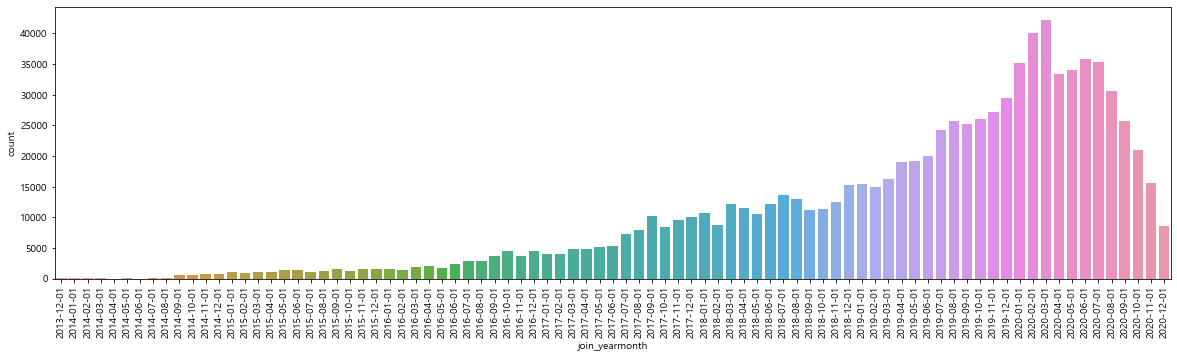

In [103]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation = 90)

sns.barplot(x = df_yearmonth['join_yearmonth'], y = df_yearmonth['count'])

## 가입자 월별 user 그래프

1. 월별 user수 또한 마찬가지로 2020년을 기점으로 상승하는듯이 보이지만 하락하고 있다.
2. 다만 월별 user수는 월별 count수보다 하락세가 덜하기 때문에 count/user로 유저별 월별 count수를 나타내 볼 필요성이 있다.

<AxesSubplot:xlabel='join_yearmonth', ylabel='user_count'>

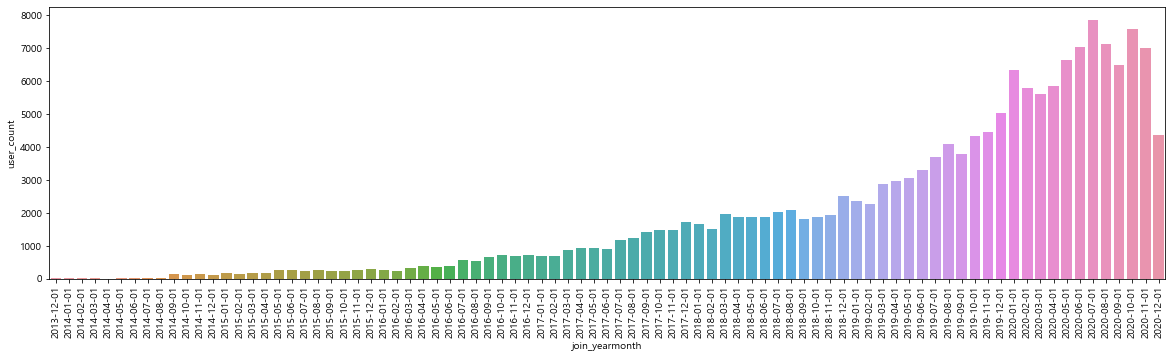

In [105]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation = 90)

sns.barplot(x = df_yearmonth['join_yearmonth'], y = df_yearmonth['user_count'])

## 월별 유저당 평균 결제건수

1. 전체기간동안 유저당 평균 6.14건을 결제하였다. 
2. 13~ 14까지 변화폭이 큰 이유는 해당 년도에 가입자 수가 많지 않기 때문에 분포가 큰 것.
3. 여기서 중요한 Insight는 2020년기점으로 유저당 평균 결제 건수가 줄어든다는 점이다.★★
   - 위에서 말했듯이 2020년도 가입 user는 결제 기간에 대한 count에 대하여 불평등이 있다. 
   - 하지만 결제 1회(즉, 유저 수)에 한해서는 불평등이 크게 존재하지 않는다.(단 한번만 결제하면 되기 때문) 
   - 따라서 위에 그래프에서 보이는 것 처럼 count는 2020을 기준으로 급격하게 줄어들지만 user수는 그렇지 않다.
   - 때문에 2020년이후에 유저당 평균 결제건수가 줄어드는 것은 지켜봐야될 지표

<AxesSubplot:xlabel='join_yearmonth', ylabel='average_count'>

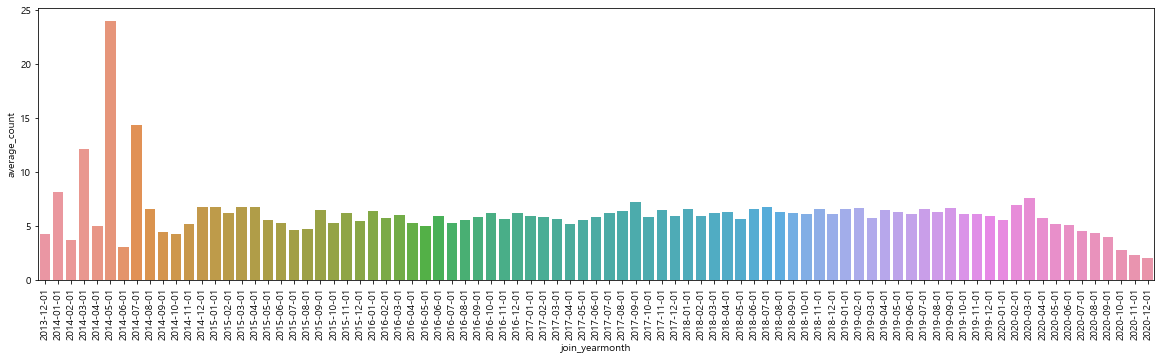

In [106]:
plt.figure(figsize = (20, 5))
plt.xticks(rotation = 90)
sns.barplot(x = df_yearmonth['join_yearmonth'], y = df_yearmonth['average_count'])

### 따라서 전체기간 인당 평균 결제수는 

따라서 가중치 계산
 1. join_date가 2020년 이전인 데이터
 2.  weight x (366 / 해당날짜 유저수)

In [108]:
#평균 df_new_year['average_count'].mean()으로 하면X 가입자 수는 2013부터 증가하기때문에 동등한 가중치로 볼 수 없기 때문

df= df.sort_values(by='join_date')
weight = df.query('join_date < datetime(2020, 1, 1)')['count'].sum()  / df.query('join_date < datetime(2020, 1, 1)')['user_id'].nunique()
weight

#전체기간 인당 평균 결제수 weight = 6.1450817...

6.145081742624897

## 2021년 예측

### 위 데이터로 2021년 데이터 그래프를 그려보자

1. 가입일자가 2013~2020년도인 유저들의 2020년도 결제 그래프를 통해 위와 같이 해당 추이를 살펴보았다.
2. 해당 추이를 통해 2020년도 가입자에 한해 count가중치를 준다.
3. 따라서 가입일자가 2013~2020년도인 유저들의 2021년도 결제 그래프를 만들어 보자.

### Real Count 유도 ★★★

1. 2020년 가입자들은 해당 데이터에서 count에 한해 '기한적 손해'를 보고 있다.
2. 따라서 '손해를 본 기간'만큼의 가중치를 해당 count에 더해서 real_count를 만들어 준다.
3. 해당 공식은 이렇다

   ### real_count   =   (count  +  ((weight/366)  *  (손해 기간)) / (total_count))  *  (weight/total_count)
   <br>
   * weight = 유저별 월평균 결제 건수 <br>
   * total_count = 유저의 전체 결제 건수 <br>
   * 손해 기간 = 가입일자로부터 2020년 1월 1일 사이의 날짜 수 <br>


In [109]:
from datetime import datetime
##total_count
df2 = df.groupby(['join_year', 'user_id'])['count'].sum().reset_index()
df2.rename(columns = {"count": "total_count"}, inplace = True)
df_final = pd.merge(df, df2, left_on = 'user_id', right_on = 'user_id', how='outer')

##real_count 계산
df_final['real_count'] = (df_final['count'] + ((weight / 366) * df_final['join_date'].dt.dayofyear.astype(int))/df_final['total_count']) * (weight/(df_final['total_count'] / df_final['count']))


In [114]:
# 2020년 이전 가입자들의 real_count = 1로 변경 (가중치가 없기 때문)
df_final.loc[:528339, 'real_count'] = df['count']
df_final.head(3)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,join_year_x,pay_yearmonth,pay_dow,join_year_y,total_count,real_count
0,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2013,2020-12,Wednesday,2013,2,1.0
1,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2013,2020-1,Sunday,2013,2,1.0
2,232,2013-12-17,BB,220077,C,2020-05-02,1,JRR,2013-12,2013,2020-5,Saturday,2013,24,1.0



## 2021년도 예상 그래프

※ 2021년도 1회이상 결제 가입자중 2013~2020년도에 가입한 유저

<AxesSubplot:xlabel='join_yearmonth', ylabel='real_count'>

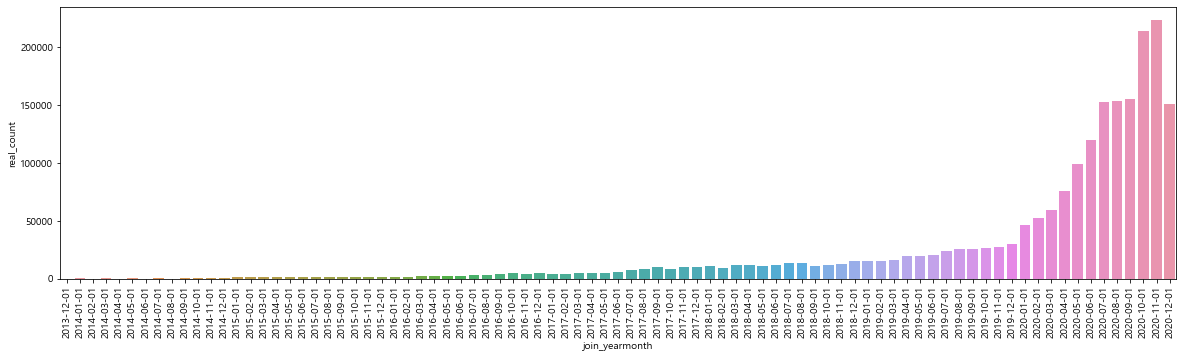

In [93]:
df_visualize = df_final.groupby('join_yearmonth')['real_count'].sum().reset_index()
df_visualize['join_yearmonth'] = df_visualize['join_yearmonth'].apply(lambda X : pd.to_datetime(X))
df_visualize = df_visualize.sort_values(by='join_yearmonth')
df_visualize = df_visualize.astype({'join_yearmonth':'str'})
df_visualize.reset_index()
plt.figure(figsize=(20, 5))
plt.xticks(rotation = 90)
sns.barplot(x = df_visualize['join_yearmonth'], y = df_visualize['real_count'])

### 그래프 해석

1. count가 급격하게 증가하는 것을 볼 수 있다.
2. 2020-12에 감소하는데, 2020 12년도 가입자에 대한 결측 데이터가 있는 것으로 추측된다.
3. 2020-11 가입자의 21년도 예상 count는 20만건이 넘는다.

# Business Insight

## 재결재율

1. 해당 데이터의 재결재율은 어떻게 될까?
2. 예를들어 한번 결재한 사람의 재결재율과 10번 결재한 사람의 재결재율은 어떻게 다를까?

In [112]:
##한번이라도 결재한 사람의 재결재 비율 (2020년)
df_user = df.groupby('user_id')['count'].sum().reset_index()
df_user

,user_id,count
0,224,2
1,232,24
2,342,1
3,565,2
4,729,1
...,...,...
165155,1830551,1
165156,1830570,1
165157,1830580,1
165158,1830589,1


In [21]:
##한번 이상 결재한 사람의 재결재 비율 (2020년)

pay_more_than_2 = df_user.query('count > 1')['user_id'].count() / df_user.query('count >= 1')['user_id'].count()
pay_more_than_2

0.5532090094453863

In [22]:
##두번 이상 결재한 사람의 재결재 비율 (2020년)

pay_more_than_2 = df_user.query('count > 2')['user_id'].count() / df_user.query('count >= 2')['user_id'].count()
pay_more_than_2

0.7067572892040977

In [23]:
##함수로 만들어서 적용

def pay_again_rate(column, count):
    
    pay_rate = df_user.query(f'count > {count}')[f'{column}'].count() / df_user.query(f'count >= {count}')[f'{column}'].count()
    
    return pay_rate

<BarContainer object of 49 artists>

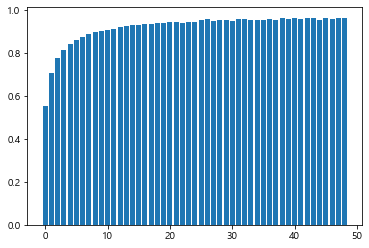

In [24]:
pay_again_list = []

for i in range(1, 50):
    
    pay_again_list.append(pay_again_rate('user_id', i))
    
pay_again_list

plt.bar(np.arange(len(pay_again_list)), pay_again_list)

### 인사이트

1. 한번이라도 결재한사람의 두번쨰 결재율은 55%정도 된다.
2. 반면 10번이상 결재한 사람의 11번째 결재율은 90% 이상이다.

- 비즈니스 적으로 한번 결재한사람의 재결재율을 끌어올릴 수 있다면 매출상승에 큰 도움이 될 것.
- 또한 10번이상 결재한 'Steady user'들을 계속해서 유지해나갈 방법또한 필요해 보임